## Download some dogs

Lets start by downloading a bunch of random dog images to use as examples.

Below, I've set the number to 100, but you can change it to more or less if you like. This took about 10 seconds on my home network.

Each time you run the two cells below it will try to download N new images, ignoring duplicates. So if you run them 3 times, odds are good you end up with about 300 images. All images will be saved to the `example_dog_images` folder. Drag/save any images you want to test with to that folder. 

In [44]:
# number of dog images to try and download
N = 100

In [45]:
import os
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed

folder_path = "example_dog_images"

def download_image(url, folder):
    response = requests.get(url)
    if response.status_code == 200:
        filename = url.split("/")[-1]
        filepath = os.path.join(folder, filename)
        if not os.path.exists(filepath): 
            with open(filepath, "wb") as f:
                f.write(response.content)
            return filepath
    return None

os.makedirs(folder_path, exist_ok=True)

# Get N random dog image URLS
response = requests.get(f"https://dog.ceo/api/breeds/image/random/{N}")
urls = response.json()["message"]

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(download_image, url, folder_path) for url in urls]
    for future in as_completed(futures):
        filepath = future.result()
        if filepath:
            print(f"Downloaded: {filepath}")

Downloaded: example_dog_images/n02113023_6015.jpg
Downloaded: example_dog_images/n02085936_797.jpg
Downloaded: example_dog_images/n02096051_6747.jpg
Downloaded: example_dog_images/n02109961_623.jpg
Downloaded: example_dog_images/n02092339_2103.jpg
Downloaded: example_dog_images/n02110185_10898.jpg
Downloaded: example_dog_images/n02085620_8491.jpg
Downloaded: example_dog_images/ebba_002.jpg
Downloaded: example_dog_images/2.jpg
Downloaded: example_dog_images/hhh_plott002.jpg
Downloaded: example_dog_images/n02113799_4046.jpg
Downloaded: example_dog_images/Indian_Mastiff.jpg
Downloaded: example_dog_images/n02096177_181.jpg
Downloaded: example_dog_images/n02102973_1725.jpg
Downloaded: example_dog_images/n02098413_14328.jpg
Downloaded: example_dog_images/n02092339_4906.jpg
Downloaded: example_dog_images/n02096294_4583.jpg
Downloaded: example_dog_images/n02106382_4504.jpg
Downloaded: example_dog_images/n02097298_3521.jpg
Downloaded: example_dog_images/n02109525_2737.jpg
Downloaded: example_do

Let's take a peek at some of the images that we've downloaded. You can run this cell multiple times to see more examples.

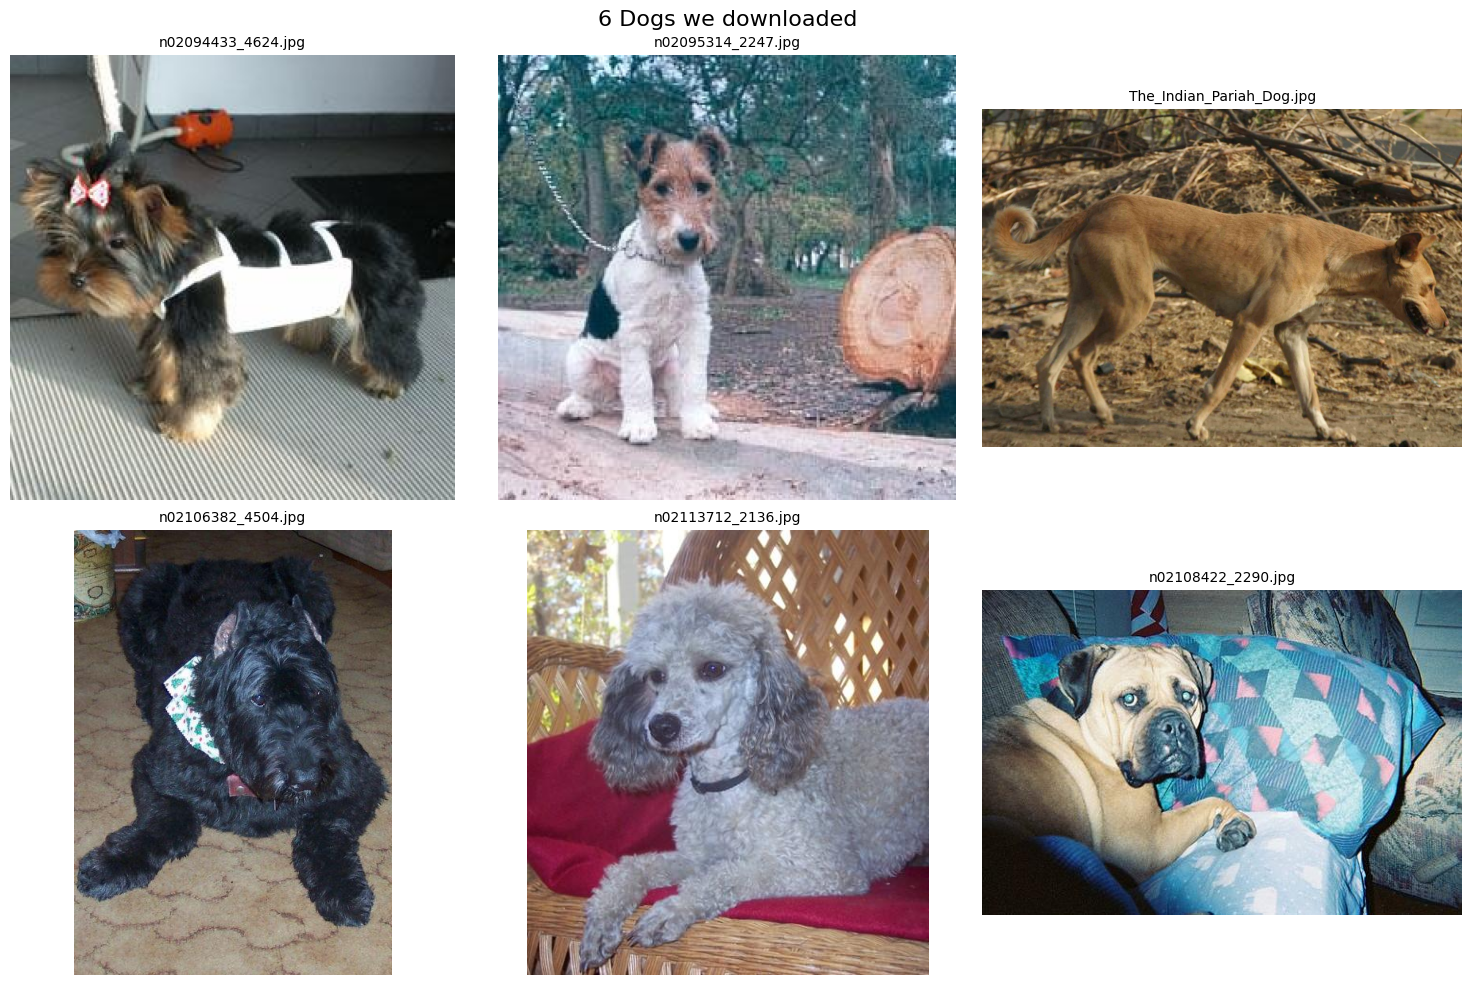

In [46]:
import random
from PIL import Image
import matplotlib.pyplot as plt

# Get all image files from the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Randomly select 6 images
random_images = random.sample(image_files, 6)

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('6 Dogs we downloaded', fontsize=16)

# Plot each image
for ax, image_file in zip(axes.ravel(), random_images):
    img = Image.open(os.path.join(folder_path, image_file))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(image_file, fontsize=10)

plt.tight_layout()
plt.show()

## Download some models

Time for a dash of machine learning 😈. Let's download some models. This took a couple of minutes on my home network.

In [47]:
import torch
import pickle
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm


# paths and file types
image_types = (".png", ".jpg", ".jpeg", ".gif")
embeddings_cache = "dogs_embeddings.pkl"


def get_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
        return outputs.cpu().numpy().flatten()
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None


def calculate_dog_embeddings(folder_path):
    embeddings = {}
    image_files = [
        f for f in os.listdir(folder_path) if f.lower().endswith(image_types)
    ]

    for image_file in tqdm(image_files, desc="Calculating dog embeddings"):
        image_path = os.path.join(folder_path, image_file)
        embedding = get_embedding(image_path)
        embeddings[image_file] = embedding

    return embeddings


# load model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cude" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)

print(f"Using device: {device}")

cache_path = os.path.join(folder_path, embeddings_cache)
if os.path.exists(cache_path):
    with open(cache_path, "rb") as f:
        dog_embeddings = pickle.load(f)
        print(f"Loaded cached embeddings found at: {cache_path}")
else:
    dog_embeddings = calculate_dog_embeddings(folder_path)
    with open(cache_path, "wb") as f:
        pickle.dump(dog_embeddings, f)
    print(f"Calculated embeddings for {len(dog_embeddings)} images.")
    print(f"Saved to: {cache_path}")

Using device: mps
Loaded cached embeddings found at: example_dog_images/dogs_embeddings.pkl


In [48]:
from scipy.spatial.distance import cosine

def find_doggleganger(selfie_path, dog_embeddings, top_n=3):
    selfie_embedding = get_embedding(selfie_path)

    similarities = {}
    for dog_file, dog_embedding in dog_embeddings.items():
        similarity = 1 - cosine(selfie_embedding, dog_embedding)
        similarities[dog_file] = similarity

    # sort in descending order and get the top_n results
    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    return sorted_similarities[:top_n]

Ok, finally time to find your DOGGLEGANGER.

Upload/save an image by drag-and-dropping it into the sidebar. On my machine I added Lizzy's selfie and called it `lizzie_selfie.png`.

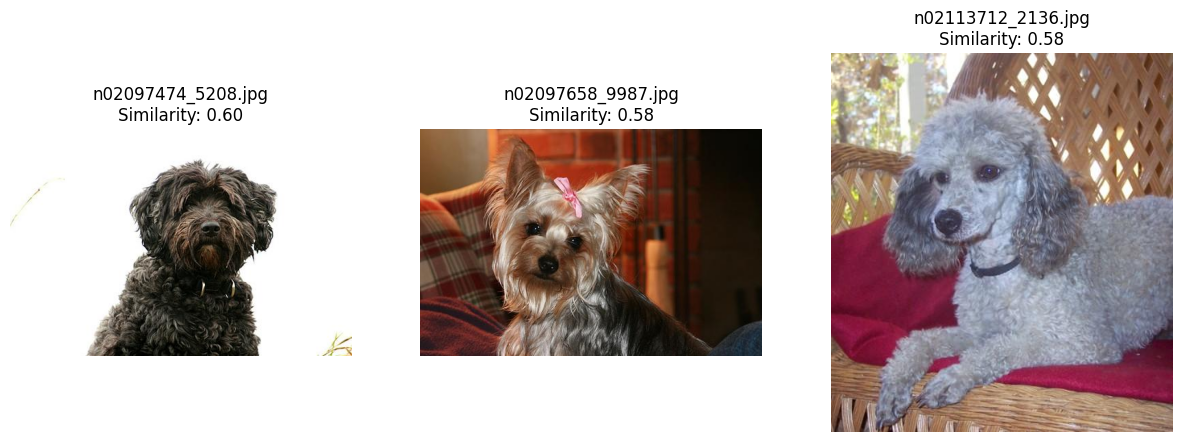

In [49]:
# enter the selfie path here
selfie_path = 'lizzie_selfie.png'

top_results = find_doggleganger(selfie_path, dog_embeddings)

plt.figure(figsize=(15, 5))
for idx, (dog_file, similarity) in enumerate(top_results):
    dog_filepath = os.path.join(folder_path, dog_file)
    img = Image.open(dog_filepath)  # open the image file
    plt.subplot(1, len(top_results), idx + 1)  # create a subplot for each image
    plt.imshow(img)  # display the image
    plt.title(f'{dog_file}\nSimilarity: {similarity:.2f}')
    plt.axis('off')  # hide axis

plt.show()

Now let's try it with our example images -- Lizzie and Ophelia (did i remember right?). Ideally, this should have a higher similarity than any of the other images from our dataset.

Note: we're going to give ourselves some grace if the similarity is NOT higher. That's because so far, we're just using an off-the-shelf embedding model. We haven't done any training to try and capture "similar" images, we're basically just crossing our fingers that the raw images produce similar features. Maybe the background color or something.

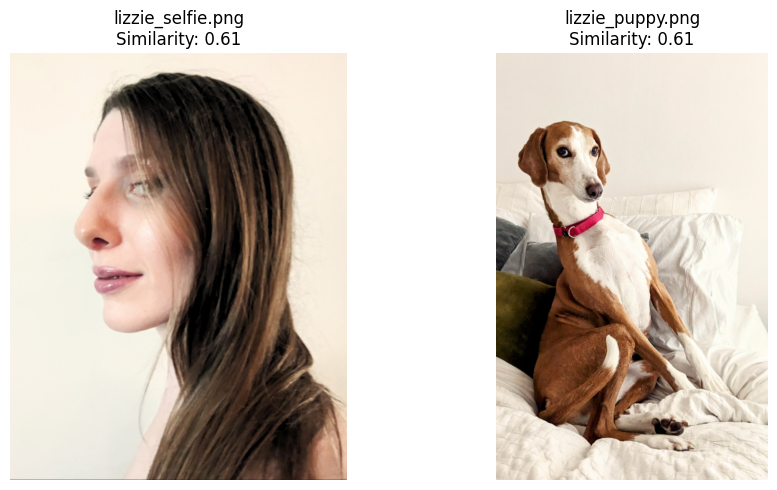

In [50]:
# If you want to try and compare two specific images here, just to play around with it, simply paste their paths into the `selfie` and `dog` variables below
selfie = 'lizzie_selfie.png'
dog = 'lizzie_puppy.png'

selfie_embedding = get_embedding(selfie)
dog_embedding = get_embedding(dog)

similarity = 1 - cosine(selfie_embedding, dog_embedding)


plt.figure(figsize=(10, 5))
for i, im in enumerate([selfie, dog]):
    img = Image.open(im)  # open the image file
    plt.subplot(1, 2, i+1)  # create a subplot for each image
    plt.imshow(img)  # display the image
    plt.title(f'{im}\nSimilarity: {similarity:.2f}')
    plt.axis('off')  # hide axis

plt.tight_layout()
plt.show()

It kinda works!!!

### Next Steps
- **Add training**: Whip up like, 10-50 training examples and make sure that we can train an alignment layer between "golden" pairs of selfies and dogs. Essentially, we should be able to make sure that Lizzie/Puppy has a similarity of 0.99. This won't be perfect with only a few dozen examples, but it'll be quick and prove the case.
- **Spotcheck PetFinder**: I think the biggest potential risk is that we just don't get back very many dogs, for most "reasonable" location/distance pairs, or that the pictures we get back from PetFinder are pretty bad. Basically, what if you live in the suburbs and set your location to like 5 miles, and there's only 8 dogs up for adoption near you and their pictures are all bad. I'll whip up a notebook to hit that API and just let us play with it directly so we can validate if we even get a reasonable number of cute dogs back from it.